In [15]:

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from __future__ import print_function
from pprint import pprint
from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from astropy.table import Table
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
tpf = KeplerTargetPixelFile.from_archive(220381074)   #KeplerTargetPixelFile
lc = tpf.to_lightcurve(aperture_mask='all')           #KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()  
print(lc.flux)

[7916.004  7931.981  7910.661  ... 7843.703  7822.35   7789.4023]


In [17]:
import lightkurve.injection as inj
import lightkurve.lightcurve as lightcurve

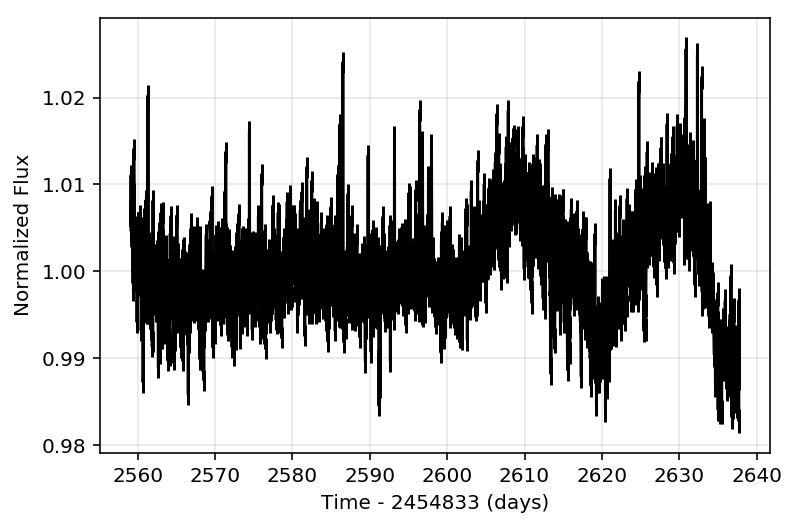

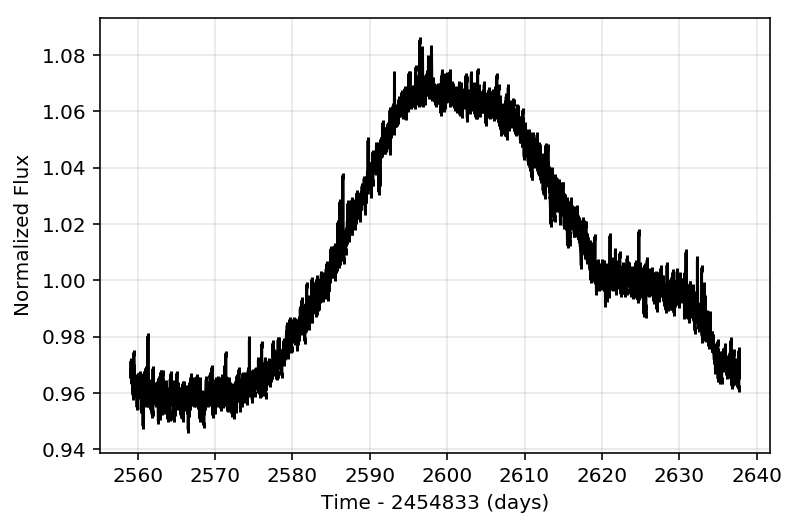

In [18]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=3.e-4)
lcinj = inj.inject(lc, model)
lc.plot()
lcinj.plot();

In [19]:
lcinj = lcinj.remove_nans()
lcinj = lcinj.normalize()

In [37]:
fit = inj.recover(lcinj, 'Supernova')
print(fit)

/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


[1.00302727e-02 1.19805060e-02 9.37810894e-03 ... 2.02052937e+02
 2.01862262e+02 2.01672967e+02]
[1.00302727e-02 1.19805060e-02 9.37810894e-03 ... 2.02052938e+02
 2.01862262e+02 2.01672967e+02]
[1.00302727e-02 1.19805060e-02 9.37810894e-03 ... 2.02052941e+02
 2.01862265e+02 2.01672970e+02]
[1.00302727e-02 1.19805060e-02 9.37810894e-03 ... 2.02062062e+02
 2.01871378e+02 2.01682074e+02]
[1.00302578e-02 1.19804911e-02 9.37809404e-03 ... 2.02052937e+02
 2.01862262e+02 2.01672967e+02]
[1.00302727e-02 1.19805060e-02 9.37810894e-03 ... 2.02052937e+02
 2.01862262e+02 2.01672967e+02]
[1.00308942e-02 1.19811274e-02 9.37873039e-03 ... 6.17760930e+05
 6.17169116e+05 6.16577190e+05]
[1.00308942e-02 1.19811274e-02 9.37873039e-03 ... 6.17760930e+05
 6.17169116e+05 6.16577190e+05]
[1.00308942e-02 1.19811274e-02 9.37873039e-03 ... 6.17760930e+05
 6.17169117e+05 6.16577190e+05]
[1.00308942e-02 1.19811274e-02 9.37873039e-03 ... 6.17760940e+05
 6.17169127e+05 6.16577200e+05]
[1.00308942e-02 1.19811274e-02

ValueError: bandpass 'kepler' [3640, .., 9190] outside spectral range [4.17555e+08, .., 1.04389e+10]

In [8]:
model_fit = inj.SupernovaModel(T0=fit[0], source='hsiao', bandpass='kepler', z=fit[1], amplitude=fit[2])
model_eval = model_fit.evaluate(lc.time)

print(model_eval)
print(lc.flux)

print(np.nanmedian(lc.flux))

model_eval = model_eval + np.nanmedian(lc.flux)
model_eval = model_eval / np.nanmedian(model_eval)
model_synth_fit = lightcurve.SyntheticLightCurve(lc.time, flux=model_eval)


KeyError: 0

In [ ]:
#lcinj.plot()
plt.plot(lc.time, lcinj.flux, color='k')
plt.plot(lc.time, model_synth_fit.flux, color='red', lw=2, ls='-',
        alpha=0.8)
#model_synth_fit.plot()

In [ ]:
tpf = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

In [ ]:
model = inj.TransitModel()
model.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model.add_planet(period=5, T0=134, rprs=.1, impact=0.0)


lc_transit = inj.inject(lc, model)
lc_transit = lc_transit.normalize()

In [ ]:
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)

In [ ]:
fit = inj.recover(lc_transit, 'Planet')
print(fit)
#T0, period, rprs, impact = theta

In [301]:
model_fit = inj.TransitModel()
model_fit.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model_fit.add_planet(period=fit[1], T0=fit[0], rprs=fit[2], impact=fit[3])
model_fit = model_fit.evaluate(lc.time)

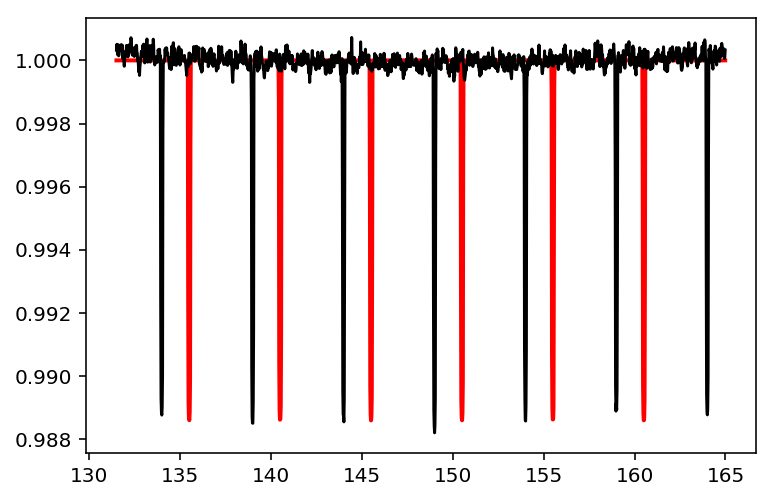

In [302]:
plt.plot(lc.time, model_fit, color = 'r', lw=2)
plt.plot(lc.time, lc_transit.flux, color='k')